In [30]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/500 - Train Loss : 1.047184 / Val Loss : 1.001686
[00:37] Epoch 100/500 - Train Loss : 0.954827 / Val Loss : 1.015512
[01:15] Epoch 200/500 - Train Loss : 0.857422 / Val Loss : 1.035131
[01:53] Epoch 300/500 - Train Loss : 0.785515 / Val Loss : 1.096755
[02:30] Epoch 400/500 - Train Loss : 0.747479 / Val Loss : 1.153378
[03:08] Epoch 500/500 - Train Loss : 0.705145 / Val Loss : 1.201067
Train MAE : 0.6298 | Train MAPE  : 3.5788 | Train RMSE : 0.8252 | Train Theil-U 0.5483
Valid MAE : 0.8482 | Valid MAPE  : 2.1933 | Valid RMSE : 1.0959 | Valid Theil-U 0.7202


### Evaluation

In [10]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


In [9]:
model.evaluate_bis(testloader, mu=testmu, sigma=testsigma)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


### PREDICT

(array([  7.,  10.,  17.,  82., 102.,  64.,  25.,  10.,   3.,   1.]),
 array([-0.01084351, -0.0084229 , -0.00600229, -0.00358168, -0.00116106,
         0.00125955,  0.00368016,  0.00610077,  0.00852138,  0.010942  ,
         0.01336261]),
 <a list of 10 Patch objects>)

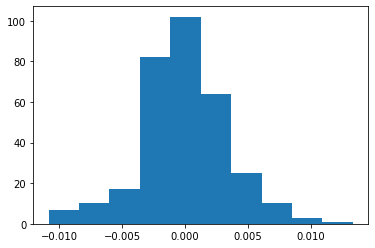

In [11]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

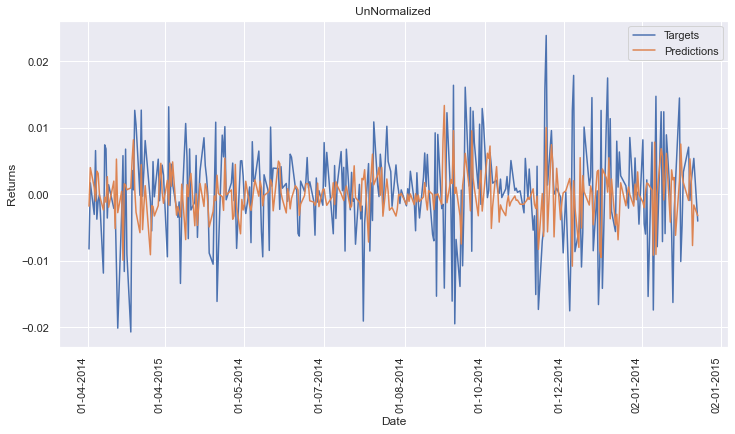

In [13]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [50]:
ETF = 'QQQ'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:32] Epoch 100/200 - Train Loss : 0.014463 / Val Loss : 0.005774
[01:03] Epoch 200/200 - Train Loss : 0.014175 / Val Loss : 0.006009
Train MAE : 0.0886 | Train MAPE  : 0.1706 | Train RMSE : 0.1172 | Train Theil-U 0.1027
Valid MAE : 0.0611 | Valid MAPE  : 0.1062 | Valid RMSE : 0.0775 | Valid Theil-U 0.0684


Normalized Test MAE : 0.007384 | Test MAPE  : 4027.963181 | Test RMSE : 0.009217 | Test Theil-U 0.774199
Test MAE : 0.007384 | Test MAPE  : 1808722958671.989990 | Test RMSE : 0.009217 | Test Theil-U 0.774199


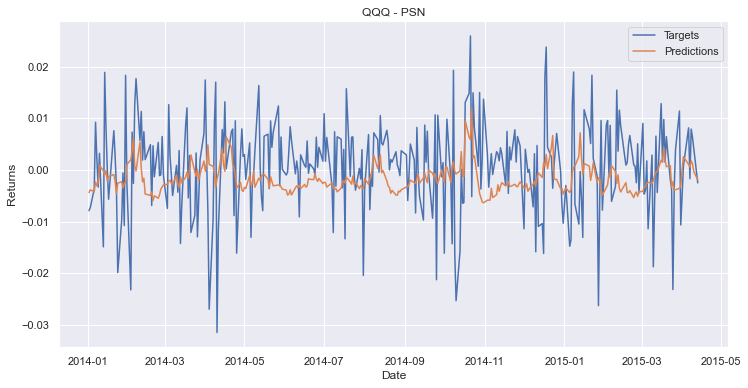

In [51]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_, max_=max_)
    preds = model.predict(testloader, min_=min_, max_=max_)
    labels = testdf["Target"]*(max_ - min_) + min_
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = np.sqrt(mean_squared_error(labels, preds))
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show() 

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.035278 / Val Loss : 0.998223
[00:32] Epoch 100/500 - Train Loss : 0.891023 / Val Loss : 0.999400
[01:08] Epoch 200/500 - Train Loss : 0.840888 / Val Loss : 1.036606
[01:48] Epoch 300/500 - Train Loss : 0.798713 / Val Loss : 1.085648
[02:28] Epoch 400/500 - Train Loss : 0.776843 / Val Loss : 1.157685
[03:05] Epoch 500/500 - Train Loss : 0.758917 / Val Loss : 1.251178
Train MAE : 0.6288 | Train MAPE  : 3.1745 | Train RMSE : 0.8638 | Train Theil-U 0.5730
Valid MAE : 0.8666 | Valid MAPE  : 1.7729 | Valid RMSE : 1.1186 | Valid Theil-U 0.7230
Normalized Test MAE : 0.005889 | Test MAPE  : 2.242785 | Test RMSE : 0.007971 | Test Theil-U 0.712896
Test MAE : 0.005905 | Test M

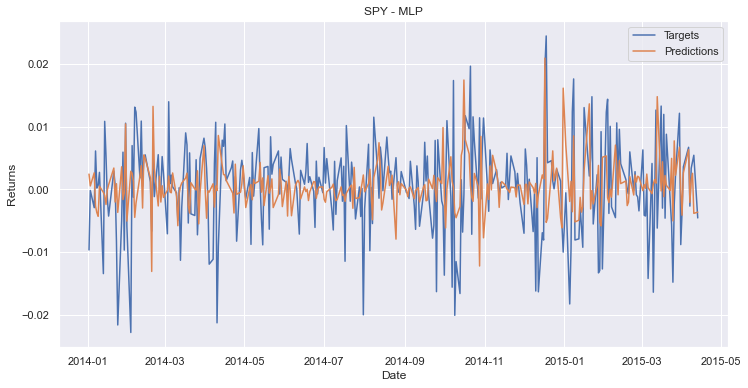




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.048547 / Val Loss : 1.005612
[01:01] Epoch 100/500 - Train Loss : 0.819822 / Val Loss : 1.172594
[01:58] Epoch 200/500 - Train Loss : 0.776743 / Val Loss : 1.174368
[02:50] Epoch 300/500 - Train Loss : 0.757038 / Val Loss : 1.193256
[03:37] Epoch 400/500 - Train Loss : 0.748702 / Val Loss : 1.211762
[04:25] Epoch 500/500 - Train Loss : 0.742301 / Val Loss : 1.226631
Train MAE : 0.6238 | Train MAPE  : 2.8459 | Train RMSE : 0.8420 | Train Theil-U 0.5462
Valid MAE : 0.8311 | Valid MAPE  : 1.8480 | Valid RMSE : 1.1075 | Valid Theil-U 0.7301
Normalized Test MAE : 0.005933 | Test MAPE  : 2.294425 | Test RMSE : 0.007822 | Test Theil-U 0.700378
Test MAE : 0.005942 | Test MAPE  : 269.661799 | Test RMSE : 0.007814 | Test Theil-U 0

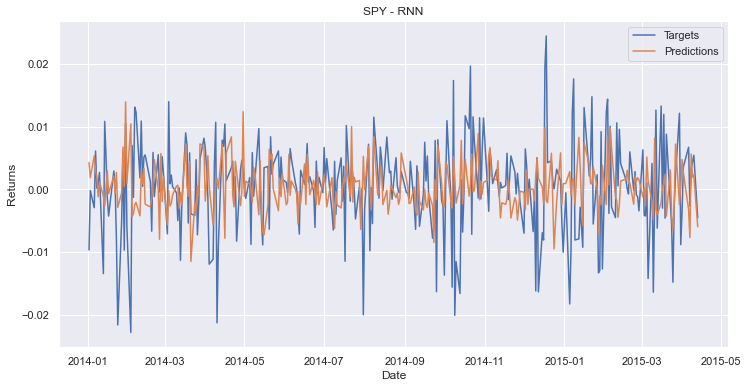




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.014059 / Val Loss : 0.005153
[00:33] Epoch 100/200 - Train Loss : 0.012877 / Val Loss : 0.007532
[01:05] Epoch 200/200 - Train Loss : 0.012619 / Val Loss : 0.007686
Train MAE : 0.0918 | Train MAPE  : 0.1618 | Train RMSE : 0.1201 | Train Theil-U 0.1019
Valid MAE : 0.0747 | Valid MAPE  : 0.1209 | Valid RMSE : 0.0877 | Valid Theil-U 0.0755
Normalized Test MAE : 0.003350 | Test MAPE  : 0.969495 | Test RMSE : 0.003917 | Test Theil-U 0.346402
Test MAE : 0.003350 | Test MAPE  : 96.949355 | Test RMSE : 0.003917 | Test Theil-U 0.346402


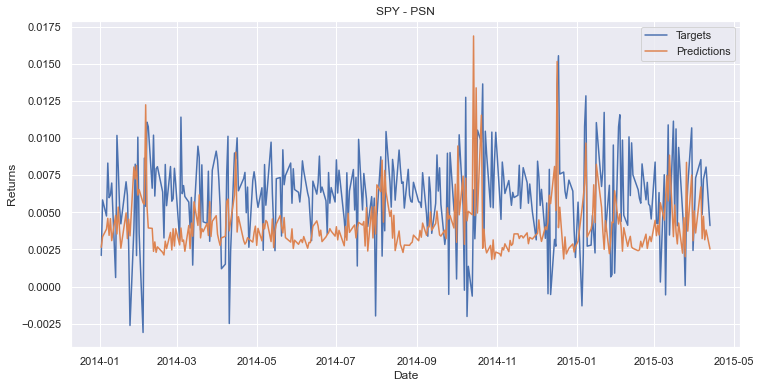




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.008304 / Val Loss : 1.003054
[00:32] Epoch 100/500 - Train Loss : 0.922898 / Val Loss : 1.034447
[01:04] Epoch 200/500 - Train Loss : 0.775836 / Val Loss : 1.108202
[01:36] Epoch 300/500 - Train Loss : 0.715731 / Val Loss : 1.234460
[02:08] Epoch 400/500 - Train Loss : 0.684499 / Val Loss : 1.318577
[02:40] Epoch 500/500 - Train Loss : 0.667886 / Val Loss : 1.375852
Train MAE : 0.6129 | Train MAPE  : 2.5966 | Train RMSE : 0.8018 | Train Theil-U 0.5143
Valid MAE : 0.9174 | Valid MAPE  : 2.7044 | Valid RMSE : 1.1730 | Valid Theil-U 0.7228
Normalized Test MAE : 0.006116 | Test MAPE  : 521.733616 | Test RMSE : 0.008149 | Test Theil-U 0.699183
Test MAE : 0.006125 | T

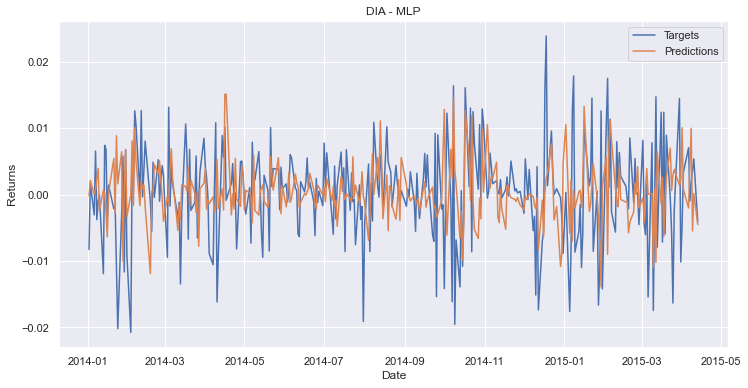




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.027126 / Val Loss : 1.011097
[00:45] Epoch 100/500 - Train Loss : 0.787646 / Val Loss : 1.239733
[01:30] Epoch 200/500 - Train Loss : 0.748902 / Val Loss : 1.235606
[02:15] Epoch 300/500 - Train Loss : 0.727586 / Val Loss : 1.219244
[03:00] Epoch 400/500 - Train Loss : 0.719352 / Val Loss : 1.229119
[03:45] Epoch 500/500 - Train Loss : 0.714038 / Val Loss : 1.232821
Train MAE : 0.6261 | Train MAPE  : 3.5984 | Train RMSE : 0.8169 | Train Theil-U 0.5249
Valid MAE : 0.8665 | Valid MAPE  : 2.2250 | Valid RMSE : 1.1103 | Valid Theil-U 0.7173
Normalized Test MAE : 0.006806 | Test MAPE  : 109.896183 | Test RMSE : 0.008688 | Test Theil-U 0.775052
Test MAE : 0.006836 | Test MAPE  : 263.780171 | Test RMSE : 0.008704 | Test Theil-U

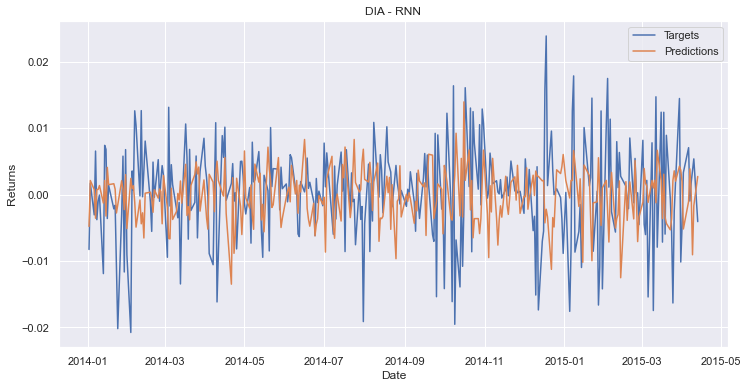




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.016897 / Val Loss : 0.005949
[00:31] Epoch 100/200 - Train Loss : 0.013843 / Val Loss : 0.006978
[01:02] Epoch 200/200 - Train Loss : 0.012752 / Val Loss : 0.007085
Train MAE : 0.0852 | Train MAPE  : 0.1622 | Train RMSE : 0.1138 | Train Theil-U 0.0977
Valid MAE : 0.0687 | Valid MAPE  : 0.1143 | Valid RMSE : 0.0842 | Valid Theil-U 0.0726
Normalized Test MAE : 0.003168 | Test MAPE  : 1.182183 | Test RMSE : 0.003910 | Test Theil-U 0.352466
Test MAE : 0.003168 | Test MAPE  : 118.218254 | Test RMSE : 0.003910 | Test Theil-U 0.352466


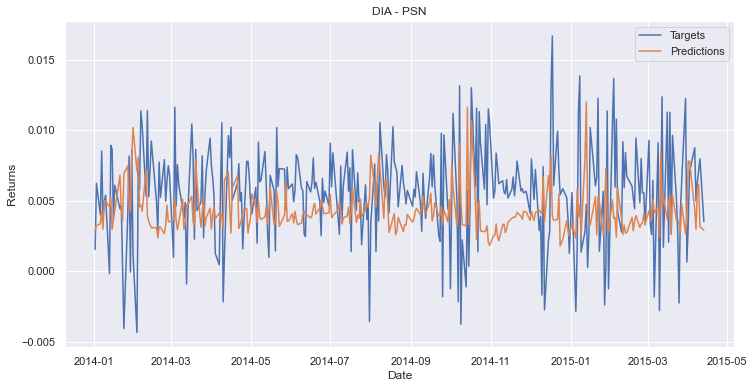




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.044693 / Val Loss : 1.008525
[00:32] Epoch 100/500 - Train Loss : 0.944701 / Val Loss : 0.989656
[01:05] Epoch 200/500 - Train Loss : 0.773699 / Val Loss : 1.129604
[01:37] Epoch 300/500 - Train Loss : 0.697623 / Val Loss : 1.284692
[02:10] Epoch 400/500 - Train Loss : 0.678927 / Val Loss : 1.333994
[03:14] Epoch 500/500 - Train Loss : 0.668115 / Val Loss : 1.359979
Train MAE : 0.6269 | Train MAPE  : 2.7893 | Train RMSE : 0.8067 | Train Theil-U 0.5036
Valid MAE : 0.8889 | Valid MAPE  : 3.2501 | Valid RMSE : 1.1662 | Valid Theil-U 0.7305
Normalized Test MAE : 0.007991 | Test MAPE  : 7.754160 | Test RMSE : 0.010308 | Test Theil-U 0.740939
Test MAE : 0.008088 | Tes

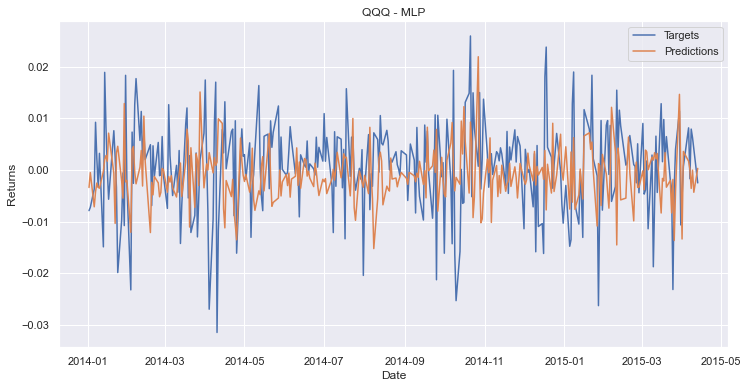




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.019351 / Val Loss : 0.989171
[00:45] Epoch 100/500 - Train Loss : 0.738911 / Val Loss : 1.251616
[01:30] Epoch 200/500 - Train Loss : 0.666638 / Val Loss : 1.368700
[02:16] Epoch 300/500 - Train Loss : 0.644983 / Val Loss : 1.441009
[03:01] Epoch 400/500 - Train Loss : 0.625992 / Val Loss : 1.466682
[03:47] Epoch 500/500 - Train Loss : 0.609395 / Val Loss : 1.520503
Train MAE : 0.5928 | Train MAPE  : 2.5096 | Train RMSE : 0.7689 | Train Theil-U 0.4660
Valid MAE : 0.9329 | Valid MAPE  : 5.8750 | Valid RMSE : 1.2331 | Valid Theil-U 0.7208
Normalized Test MAE : 0.007861 | Test MAPE  : 6.156275 | Test RMSE : 0.010512 | Test Theil-U 0.718396
Test MAE : 0.007902 | Test MAPE  : 269.250001 | Test RMSE : 0.010511 | Test Theil-U

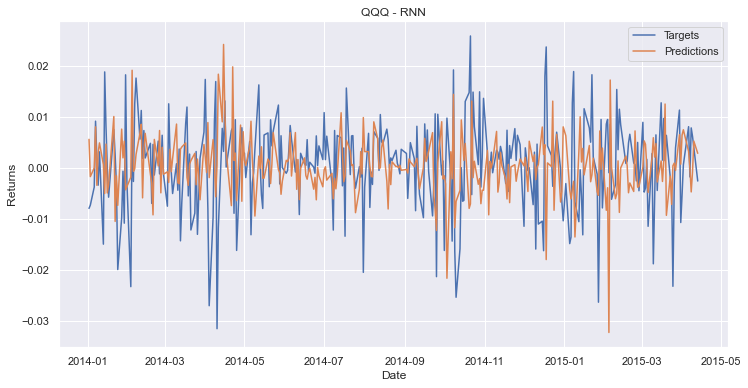




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018488 / Val Loss : 0.011347
[00:31] Epoch 100/200 - Train Loss : 0.014391 / Val Loss : 0.005913
[01:04] Epoch 200/200 - Train Loss : 0.014034 / Val Loss : 0.006233
Train MAE : 0.0888 | Train MAPE  : 0.1705 | Train RMSE : 0.1168 | Train Theil-U 0.1023
Valid MAE : 0.0624 | Valid MAPE  : 0.1084 | Valid RMSE : 0.0789 | Valid Theil-U 0.0697
Normalized Test MAE : 0.003073 | Test MAPE  : 2.347048 | Test RMSE : 0.003818 | Test Theil-U 0.373377
Test MAE : 0.003073 | Test MAPE  : 234.707192 | Test RMSE : 0.003818 | Test Theil-U 0.373377


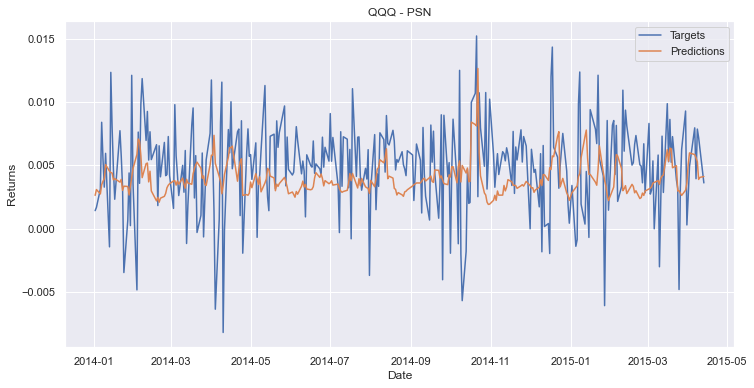

In [56]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
        epochs = 200 if NNtype == "PSN" else 500
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=testMin_, max_=testMax_)
            preds = model.predict(testloader, min_=testMin_, max_=testMax_)
            labels = testdf["Target"]*(testMax_ - testMin_) + testMin_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = np.sqrt(mean_squared_error(labels, preds))
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = 100 * mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        
        sns.set()
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

#         x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
#         ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [57]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [43]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005390 | Test MAPE  : 1.079670 | Test RMSE : 0.007245 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined